<h1 style="text-align: center;">Stable Diffusion v2.1 using Optimum-Intel OpenVINO and multiple Intel Hardware</h1>
<img src="https://github.com/openvinotoolkit/openvino_notebooks/assets/10940214/1858dae4-72fd-401e-b055-66d503d82446"  width="30%" height="30%">


Optimum Intel is the interface between the Transformers and Diffusers libraries and the different tools and libraries provided by Intel to accelerate end-to-end pipelines on Intel architectures. More details in this [repository](https://github.com/huggingface/optimum-intel#openvino). 

`Note: We suggest you to create a different environment and run the following installation command there.`

In [1]:
%pip install -q "optimum-intel[openvino,diffusers]" "ipywidgets"

Note: you may need to restart the kernel to use updated packages.


In [2]:
import warnings
warnings.filterwarnings('ignore')

### Showing Info Available Devices

The `available_devices` property shows the available devices in your system. The "FULL_DEVICE_NAME" option to `ie.get_property()` shows the name of the device. Check what is the ID name for the discrete GPU, if you have integrated GPU (iGPU) and discrete GPU (dGPU), it will show `device_name="GPU.0"` for iGPU and `device_name="GPU.1"` for dGPU. If you just have either an iGPU or dGPU that will be assigned to `"GPU"`

Note: For more details about GPU with OpenVINO visit this [link](https://docs.openvino.ai/nightly/openvino_docs_install_guides_configurations_for_intel_gpu.html). If you have been facing any issue in Ubuntu 20.04 or Windows 11 read this [blog](https://blog.openvino.ai/blog-posts/install-gpu-drivers-windows-ubuntu).

In [3]:
from openvino.runtime import Core

ie = Core()
devices = ie.available_devices

for device in devices:
    device_name = ie.get_property(device, "FULL_DEVICE_NAME")
    print(f"{device}: {device_name}")

CPU: Intel(R) Core(TM) i7-10710U CPU @ 1.10GHz
GPU: Intel(R) UHD Graphics [0x9bca] (iGPU)


### Using full precision model in CPU with StableDiffusionPipeline


2023-06-28 22:18:39.543119: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-28 22:18:39.588994: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-28 22:18:39.590115: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-28 22:18:40.429760: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

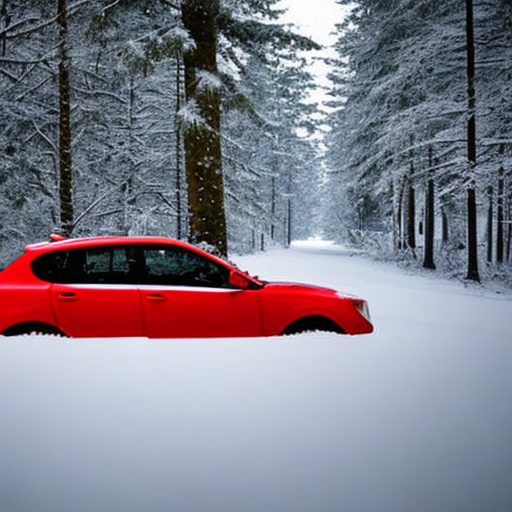

In [4]:
from diffusers import StableDiffusionPipeline

model_id = "stabilityai/stable-diffusion-2-1-base"
pipe = StableDiffusionPipeline.from_pretrained(model_id)
pipe.save_pretrained("./stabilityai_cpu")
prompt = "red car in snowy forest"
output_cpu = pipe(prompt, num_inference_steps=17).images[0]
output_cpu.save("image_cpu.png")
output_cpu

### Using full precision model in CPU with OVStableDiffusionPipeline

In [5]:
from optimum.intel.openvino import OVStableDiffusionPipeline

model_id = "stabilityai/stable-diffusion-2-1-base"
ov_pipe = OVStableDiffusionPipeline.from_pretrained(model_id, export=True, compile=False)
ov_pipe.reshape(batch_size=1, height=512, width=512, num_images_per_prompt=1)
ov_pipe.save_pretrained("./openvino_ir")
ov_pipe.compile()


INFO:nncf:NNCF initialized successfully. Supported frameworks detected: torch, tensorflow, onnx, openvino


Framework not specified. Using pt to export to ONNX.
Keyword arguments {'subfolder': '', 'config': {'_class_name': 'StableDiffusionPipeline', '_diffusers_version': '0.10.0.dev0', 'feature_extractor': ['transformers', 'CLIPImageProcessor'], 'requires_safety_checker': False, 'safety_checker': [None, None], 'scheduler': ['diffusers', 'PNDMScheduler'], 'text_encoder': ['transformers', 'CLIPTextModel'], 'tokenizer': ['transformers', 'CLIPTokenizer'], 'unet': ['diffusers', 'UNet2DConditionModel'], 'vae': ['diffusers', 'AutoencoderKL']}} are not expected by StableDiffusionPipeline and will be ignored.
Using framework PyTorch: 1.13.1+cpu
Using framework PyTorch: 1.13.1+cpu
Saving external data to one file...
Using framework PyTorch: 1.13.1+cpu
Using framework PyTorch: 1.13.1+cpu
Compiling the text_encoder...
Compiling the vae_decoder...
Compiling the unet...


  0%|          | 0/18 [00:00<?, ?it/s]

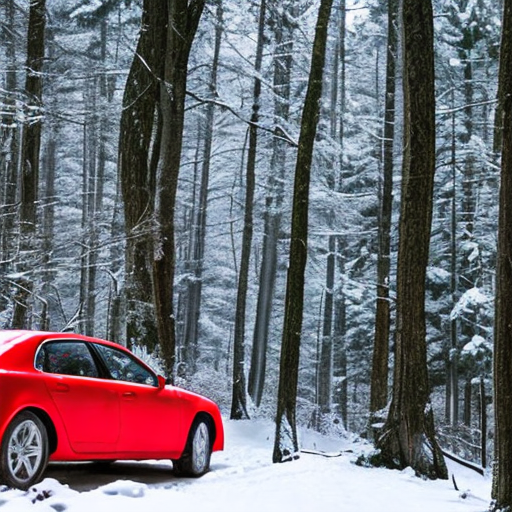

In [6]:
prompt = "red car in snowy forest"
output_cpu_ov = ov_pipe(prompt, num_inference_steps=17).images[0]
output_cpu_ov.save("image_ov_cpu.png")
output_cpu_ov

### Using full precision model in dGPU with OVStableDiffusionPipeline

The model in this notebook is FP32 precision. And thanks to the new feature of OpenVINO 2023.0 you do not need to convert the model to FP16 for running the inference on GPU.


In [7]:
ov_pipe.to("GPU")
ov_pipe.compile()

Compiling the text_encoder...
Compiling the vae_decoder...
Compiling the unet...


  0%|          | 0/18 [00:00<?, ?it/s]

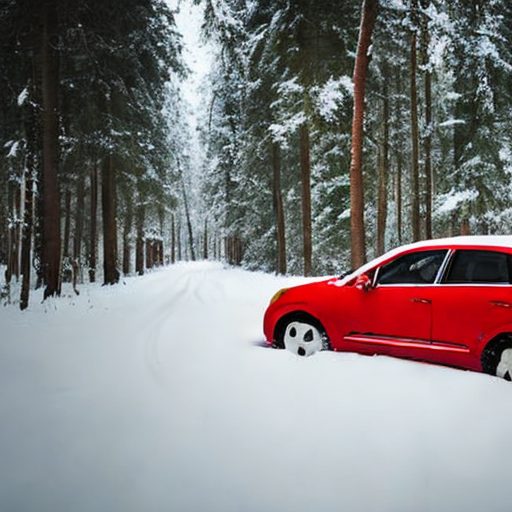

In [8]:
prompt = "red car in snowy forest"
output_gpu_ov = ov_pipe(prompt, num_inference_steps=17).images[0]
output_gpu_ov.save("image_ov_gpu.png")
output_gpu_ov